In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def load_dataset(path, resize = 256, batch_size = 32):
    transform = transforms.Compose([
        transforms.Resize((resize, resize)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    dataset = datasets.ImageFolder(root=path, transform=transform)
    # Create DataLoader
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    return data_loader

In [4]:
train_iter = load_dataset('../data/dogs_vs_cat/train', batch_size=32)
test_iter = load_dataset('../data/dogs_vs_cat/test', batch_size=32)

### Model 

In [5]:
class CNN_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding='valid'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),

            nn.Conv2d(32, 64, kernel_size=3, padding='valid'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),

            nn.Conv2d(64, 128, kernel_size=3, padding='valid'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),

            nn.Flatten(),
            nn.Linear(115200,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [6]:
from torchinfo import summary

model = CNN_model()
summary(model, input_size=(1,3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_model                                [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Conv2d: 2-1                       [1, 32, 254, 254]         896
│    └─ReLU: 2-2                         [1, 32, 254, 254]         --
│    └─MaxPool2d: 2-3                    [1, 32, 127, 127]         --
│    └─Conv2d: 2-4                       [1, 64, 125, 125]         18,496
│    └─ReLU: 2-5                         [1, 64, 125, 125]         --
│    └─MaxPool2d: 2-6                    [1, 64, 62, 62]           --
│    └─Conv2d: 2-7                       [1, 128, 60, 60]          73,856
│    └─ReLU: 2-8                         [1, 128, 60, 60]          --
│    └─MaxPool2d: 2-9                    [1, 128, 30, 30]          --
│    └─Flatten: 2-10                     [1, 115200]               --
│    └─Linear: 2-11                      [1, 128]                  14,745,72

In [7]:
# Training function
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    train_losses = []
    train_accs = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Use tqdm for progress bar
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.view(-1, 1)
            labels = labels.float().to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({'loss': running_loss/len(train_loader),
                            'accuracy': 100 * correct / total})
        
        # Calculate epoch statistics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accs


# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.view(-1, 1)
            labels = labels.float().to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Plot training progress
def plot_training_progress(train_losses, train_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot loss
    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    
    # Plot accuracy
    ax2.plot(train_accs)
    ax2.set_title('Training Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    
    plt.tight_layout()
    plt.show()


In [8]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for images, labels in train_bar:
            images = images.to(device)
            labels = labels.float().to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1))
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            train_bar.set_postfix({'loss': loss.item()})
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.float().to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels.unsqueeze(1))
                val_loss += loss.item()
                
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted.squeeze() == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        accuracy = 100 * correct / total
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print(f'Validation Accuracy: {accuracy:.2f}%')
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
    
    return train_losses, val_losses

In [9]:
lr = 0.001
epochs = 10
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the model
train_losses, val_losses = train_model(model, train_iter, test_iter, criterion, optimizer, epochs)

Epoch 1/10: 100%|██████████| 625/625 [00:51<00:00, 12.25it/s, loss=0.447]


Epoch [1/10]
Training Loss: 0.5881
Validation Loss: 0.5294
Validation Accuracy: 73.76%


Epoch 2/10: 100%|██████████| 625/625 [00:50<00:00, 12.27it/s, loss=0.395]


Epoch [2/10]
Training Loss: 0.4704
Validation Loss: 0.4387
Validation Accuracy: 79.74%


Epoch 3/10: 100%|██████████| 625/625 [00:50<00:00, 12.29it/s, loss=0.378]


Epoch [3/10]
Training Loss: 0.3714
Validation Loss: 0.4455
Validation Accuracy: 79.74%


Epoch 4/10: 100%|██████████| 625/625 [00:50<00:00, 12.26it/s, loss=0.449] 


Epoch [4/10]
Training Loss: 0.2482
Validation Loss: 0.4547
Validation Accuracy: 80.80%


Epoch 5/10: 100%|██████████| 625/625 [00:50<00:00, 12.30it/s, loss=0.0986] 


Epoch [5/10]
Training Loss: 0.1256
Validation Loss: 0.7431
Validation Accuracy: 80.96%


Epoch 6/10: 100%|██████████| 625/625 [00:50<00:00, 12.30it/s, loss=0.0665]  


Epoch [6/10]
Training Loss: 0.0534
Validation Loss: 0.9557
Validation Accuracy: 80.94%


Epoch 7/10: 100%|██████████| 625/625 [00:50<00:00, 12.26it/s, loss=0.00194] 


Epoch [7/10]
Training Loss: 0.0364
Validation Loss: 1.5708
Validation Accuracy: 79.42%


Epoch 8/10: 100%|██████████| 625/625 [00:50<00:00, 12.35it/s, loss=0.0744]  


Epoch [8/10]
Training Loss: 0.0394
Validation Loss: 0.9462
Validation Accuracy: 80.18%


Epoch 9/10: 100%|██████████| 625/625 [00:50<00:00, 12.34it/s, loss=0.0063]  


Epoch [9/10]
Training Loss: 0.0225
Validation Loss: 1.6059
Validation Accuracy: 81.10%


Epoch 10/10: 100%|██████████| 625/625 [00:50<00:00, 12.33it/s, loss=0.0116]  


Epoch [10/10]
Training Loss: 0.0167
Validation Loss: 1.3731
Validation Accuracy: 79.44%


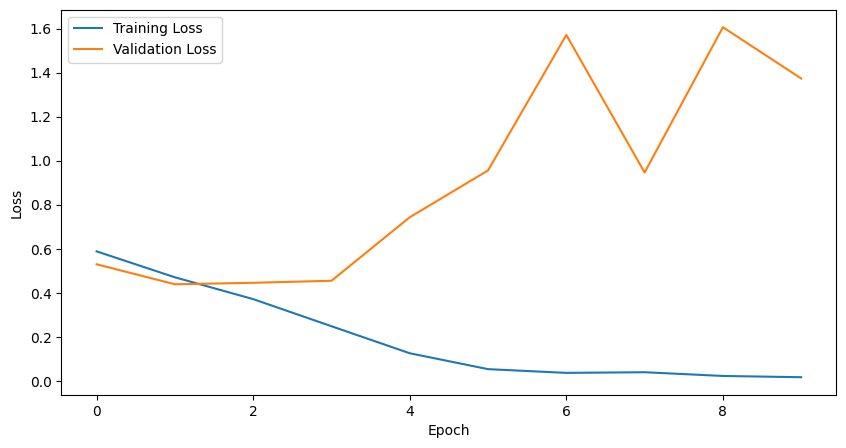

In [10]:
# Plot training results
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_plot.png')
plt.show()

In [11]:
## Overfitting